In [3]:
import pandas as pd
from datetime import datetime
from math import log
from numpy import sign
import numpy as np
import yfinance as yf
import pmdarima
import arch
from tqdm import tqdm
from dateutil import relativedelta
from statsmodels.tsa.api import VAR
import yfinance as yf
import stockstats as ss
import warnings
warnings.filterwarnings('ignore')
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web
from pandas_datareader.famafrench import FamaFrenchReader
import statistics as st
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn import metrics

# KNN, SVM, CatBoost

In [1222]:
stocks = ["SBER.ME", "MOEX.ME","VTBR.ME","AFKS.ME","NLMK.ME","MAGN.ME","CHMF.ME","MTLR.ME",
         "LKOH.ME","NVTK.ME","ROSN.ME","GAZP.ME","HYDR.ME","FEES.ME","MSNG.ME","IRAO.ME",]

svm_acc_results = {}
svm_pred_results = {}
true_observ = {}
true_observ_classified = {}
svm_all_predictions = {}

    #RUONIA
ruonia = pd.read_excel('ruonia.xlsx', index_col = 0)

    #ROISfix
roisfix = pd.read_excel('roisfix.xlsx', index_col = 0)

    #steel
steel = pd.read_excel('steel.xlsx', index_col = 0)

a = list(steel.index)
b = pd.DataFrame(a, columns = ['d'])

for bb in range(len(b)):
    b['d'][bb] = datetime.strptime(b['d'][bb], '%Y-%m-%d')

ni = b['d']
steel.set_index(ni, inplace = True)


moex = yf.download(tickers = "IMOEX.ME", interval = '1d',
                   start = startdate, end = enddate)
moex.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace = True, axis = 1)
moex['shift'] = moex['Close'].shift(1)
moex.dropna(inplace = True)
moex['ln_change_moex'] = 0
for i in tqdm(range(len(moex))):
    moex['ln_change_moex'][i] = log(moex['Close'][i] / moex['shift'][i])
moex.drop(['shift', 'Close'], inplace = True, axis = 1)



snp500 = yf.download(tickers = "%5EGSPC", interval = '1d',
                   start = startdate, end = enddate)
snp500.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace = True, axis = 1)
snp500['shift'] = snp500['Close'].shift(1)
snp500.dropna(inplace = True)
snp500['ln_change_snp500'] = 0
for i in tqdm(range(len(snp500))):
    snp500['ln_change_snp500'][i] = log(snp500['Close'][i] / snp500['shift'][i])
snp500.drop(['shift', 'Close'], inplace = True, axis = 1)



brent = yf.download(tickers = "BZ=F", interval = '1d',
                   start = startdate, end = enddate)
brent.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace = True, axis = 1)
brent['shift'] = brent['Close'].shift(1)
brent.dropna(inplace = True)
brent['ln_change_brent'] = 0
for i in tqdm(range(len(moex))):
    brent['ln_change_brent'][i] = log(brent['Close'][i] / brent['shift'][i])
brent.drop(['shift', 'Close'], inplace = True, axis = 1)



gas = yf.download(tickers = "NG=F", interval = '1d',
                   start = startdate, end = enddate)
gas.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace = True, axis = 1)
gas['shift'] = gas['Close'].shift(1)
gas.dropna(inplace = True)
gas['ln_change_gas'] = 0
for i in tqdm(range(len(gas))):
    gas['ln_change_gas'][i] = log(gas['Close'][i] / gas['shift'][i])
gas.drop(['shift', 'Close'], inplace = True, axis = 1)



usd = yf.download(tickers = "RUB=X", interval = '1d',
                   start = startdate, end = enddate)
usd.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace = True, axis = 1)
usd['shift'] = usd['Close'].shift(1)
usd.dropna(inplace = True)
usd['ln_change_usd'] = 0
for i in tqdm(range(len(usd))):
    usd['ln_change_usd'][i] = log(usd['Close'][i] / usd['shift'][i])
usd.drop(['shift', 'Close'], inplace = True, axis = 1)

rates = pd.merge(ruonia, roisfix, left_index=True, right_index=True)



for stock in stocks:
    
    svm_all_predictions[stock] = {} 
    print(stock)
    tickers = stock 
    startdate = '2014-01-01'
    enddate = '2022-01-01'

    data_raw = yf.download(tickers = tickers, interval = '1d',
                       start = startdate, end = enddate)

    data = ss.wrap(data_raw)
    data.init_all()

    df = pd.merge(data, rates, left_index=True, right_index=True)
    df = pd.merge(df, moex, left_index=True, right_index=True)
    df = pd.merge(df, snp500, left_index=True, right_index=True)
    df = pd.merge(df, brent, left_index=True, right_index=True)
    df = pd.merge(df, usd, left_index=True, right_index=True)
    df = pd.merge(df, gas, left_index=True, right_index=True)
    df = pd.merge(df, steel, left_index=True, right_index=True)

    df.drop(['open', 'high', 'low', 'close', 'adj close', 'volume', 'change'], inplace = True, axis = 1)
    df.dropna(inplace = True)

    y = df['log-ret']
    df.drop(['log-ret'], inplace = True, axis = 1)
    date_index = df.index
    df.head()

    k = 35 

    selector = SelectKBest(score_func=f_classif, k=k)  

    df_selected = selector.fit_transform(df, y)
    new_names = selector.get_feature_names_out(df.columns)

    df_selected = pd.DataFrame(df_selected, index = date_index, columns = new_names)
    df_selected.head()

    factors = 'Emerging_5_Factors'

    ff_reader = FamaFrenchReader(symbols = factors, start = startdate, end = enddate)

    ff_data = ff_reader.read()
    ff_data = pd.DataFrame(ff_data[0])
    ff_data = ff_data.drop(ff_data.index[-1])
    ff_data.head()

    a = list(date_index)
    b = pd.DataFrame(a, columns = ['d'])
    b.head()
    b['d'] = b['d'].apply(lambda x: x.strftime('%Y-%m'))
    new_index_mmyyyy = b['d']
    new_index_mmyyyy
    df_selected.set_index(new_index_mmyyyy, inplace = True)

    ffi = list(ff_data.index)
    c = pd.DataFrame(ffi, columns = ['d'])
    c['d'] = c['d'].apply(lambda x: x.strftime('%Y-%m'))
    ni = c['d']
    ff_data.set_index(ni, inplace = True)


    df_selected = pd.merge(df_selected, ff_data, left_index=True, right_index=True, how = 'left')
    df_selected.set_index(date_index, inplace = True)
    df_selected.head(10)

    df_selected = df_selected.shift(periods = 1)
    df_selected.dropna(inplace = True)

    y = y[1:]
    df_selected.tail()
    
    

    
    X = df_selected

    y_classified = []

    for val in y.values:
        if val > 0:
            y_classified.append(1)
        elif val <= 0:
            y_classified.append(0)

    train_window_size = 1200
    test_window_size = 30
    n_splits = len(df_selected) - train_window_size - test_window_size

#     clf = AdaBoostClassifier(n_estimators = 150, learning_rate=0.1, random_state=42)

#     clf = CatBoostClassifier(
#         iterations = 100, 
#         learning_rate = 0.1, 
#         loss_function = 'CrossEntropy',
#         eval_metric = 'Accuracy',
#         silent = True,
#         l2_leaf_reg = 10
#     )

#     clf = svm.NuSVC(kernel='sigmoid')

#     clf = KNeighborsClassifier(n_neighbors = 5, weights = 'distance', metric = 'l1')



    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', clf)
    ])

    accuracy_scores = []
    cum_accuracy = []

    for i in tqdm(range(n_splits)):

        train_index = train_window_size + i 
        test_index = train_index + test_window_size 

        X_train, X_test = X[i : train_index], X[train_index : test_index]
        y_train, y_test = y_classified[i : train_index], y_classified[train_index : test_index]

        if len(X_train) >= train_window_size:
            pipeline.fit(X_train, y_train)

            y_pred = pipeline.predict(X_test)
            svm_all_predictions[stock][i] = list(y_pred)

            accuracy = accuracy_score(y_test, y_pred)
            accuracy_scores.append(accuracy)
            cum_accuracy.append(np.mean(accuracy_scores))
            
    true_observ[stock] = y
    true_observ_classified[stock] = y_classified
    svm_acc_results[stock] = cum_accuracy

In [985]:
svm_final_preds_dict = {}

for stock in stocks:
    print(stock)
    final_preds_for_stock = []
    
    for i in range(len(svm_all_predictions[stock])):
        day_pred = [] 
        
        for j in range(min(i, 29), -1, -1):
            day_pred.append(svm_all_predictions[stock][i-j][j])
            
        final_preds_for_stock.append(round(np.mean(day_pred)))
        
    svm_final_preds_dict[stock] = final_preds_for_stock
    print('num of test observations:', len(final_preds_for_stock))

SBER.ME
num of test observations: 633
MOEX.ME
num of test observations: 632
VTBR.ME
num of test observations: 633
AFKS.ME
num of test observations: 631
NLMK.ME
num of test observations: 633
MAGN.ME
num of test observations: 633
CHMF.ME
num of test observations: 633
MTLR.ME
num of test observations: 632
LKOH.ME
num of test observations: 633
NVTK.ME
num of test observations: 633
ROSN.ME
num of test observations: 633
GAZP.ME
num of test observations: 632
HYDR.ME
num of test observations: 633
FEES.ME
num of test observations: 633
MSNG.ME
num of test observations: 633
IRAO.ME
num of test observations: 631


In [986]:
svm_port_acc = {}

svm_fin_acc = []
svm_oil_acc = []
svm_mm_acc = []
svm_util_acc = []

for i in range(min(len(svm_acc_results['SBER.ME']), len(svm_acc_results['MOEX.ME']),
                   len(svm_acc_results['AFKS.ME']), len(svm_acc_results['VTBR.ME']))):
               
    svm_fin_acc.append((svm_acc_results['SBER.ME'][i]+ svm_acc_results['MOEX.ME'][i]+
                               svm_acc_results['VTBR.ME'][i]+svm_acc_results['AFKS.ME'][i])/4)
    
for i in range(min(len(svm_acc_results['LKOH.ME']), len(svm_acc_results['ROSN.ME']),
                   len(svm_acc_results['NVTK.ME']), len(svm_acc_results['GAZP.ME']))):
               
    svm_oil_acc.append((svm_acc_results['LKOH.ME'][i]+ svm_acc_results['ROSN.ME'][i]+
                               svm_acc_results['NVTK.ME'][i]+svm_acc_results['GAZP.ME'][i])/4)
    
for i in range(min(len(svm_acc_results['NLMK.ME']), len(svm_acc_results['CHMF.ME']),
                   len(svm_acc_results['MAGN.ME']), len(svm_acc_results['MTLR.ME']))):
               
    svm_mm_acc.append((svm_acc_results['NLMK.ME'][i]+ svm_acc_results['CHMF.ME'][i]+
                               svm_acc_results['MAGN.ME'][i]+svm_acc_results['MTLR.ME'][i])/4)
    
for i in range(min(len(svm_acc_results['FEES.ME']), len(svm_acc_results['MSNG.ME']),
                   len(svm_acc_results['HYDR.ME']), len(svm_acc_results['IRAO.ME']))):
               
    svm_util_acc.append((svm_acc_results['FEES.ME'][i]+ svm_acc_results['MSNG.ME'][i]+
                               svm_acc_results['HYDR.ME'][i]+svm_acc_results['IRAO.ME'][i])/4)
                                                                                 
                                                                              
svm_port_acc['financials'] =  svm_fin_acc
svm_port_acc['oilngas'] =  svm_oil_acc
svm_port_acc['mm'] =  svm_mm_acc
svm_port_acc['utilities'] =  svm_util_acc
                                                                                                                                          

Text(0.5, 1.0, 'Компании сектора Utilities')

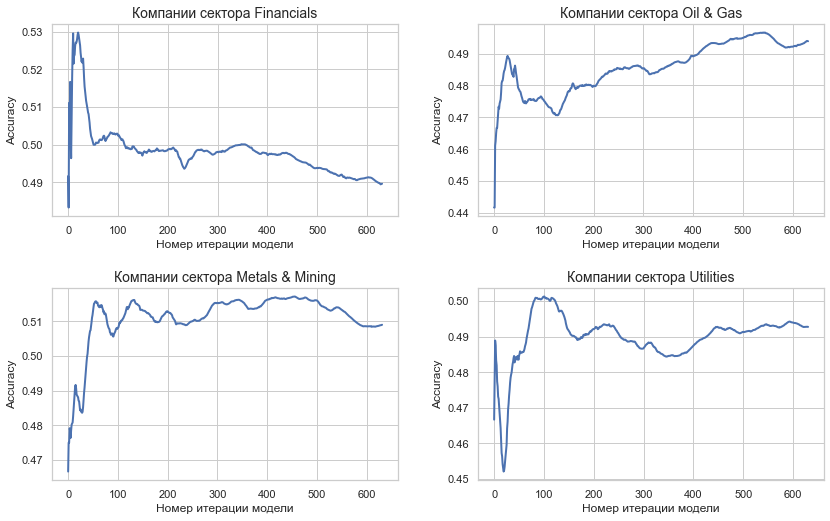

In [987]:
fontsize = 14


sns.set()
sns.set_style("whitegrid")
fig, ax = plt.subplots(2,2, figsize=(12.5,8))

fig.tight_layout(pad=4.0)

ax[0,0].plot(svm_port_acc['financials'], linewidth = 2)
ax[0,0].set(xlabel='Номер итерации модели', ylabel='Accuracy')
ax[0,0].set_title("Компании сектора Financials", fontsize = fontsize)


ax[0,1].plot(svm_port_acc['oilngas'], linewidth = 2)
ax[0,1].set(xlabel='Номер итерации модели', ylabel='Accuracy')
ax[0,1].set_title("Компании сектора Oil & Gas", fontsize = fontsize)


ax[1,0].plot(svm_port_acc['mm'], linewidth = 2)
ax[1,0].set(xlabel='Номер итерации модели', ylabel='Accuracy')
ax[1,0].set_title("Компании сектора Metals & Mining", fontsize = fontsize)


ax[1,1].plot(svm_port_acc['utilities'], linewidth = 2)
ax[1,1].set(xlabel='Номер итерации модели', ylabel='Accuracy')
ax[1,1].set_title("Компании сектора Utilities", fontsize = fontsize)

In [954]:
current_ts = cat_port_acc['utilities']
print('min accuracy:', 100*min(current_ts))
print('10 perc accuracy:', 100*np.quantile(current_ts, 0.1))
print('mean accuracy:', 100*np.mean(current_ts))
print('median accuracy:', 100*np.quantile(current_ts, 0.5))
print('90 perc accuracy:', 100*np.quantile(current_ts, 0.9))
print('max accuracy:', 100*max(current_ts))

min accuracy: 47.06060606060605
10 perc accuracy: 49.45017182130584
mean accuracy: 51.008352227317964
median accuracy: 51.15754812563323
90 perc accuracy: 52.11149961149961
max accuracy: 54.166666666666664


Text(0.5, 1.0, 'Компании сектора Utilities')

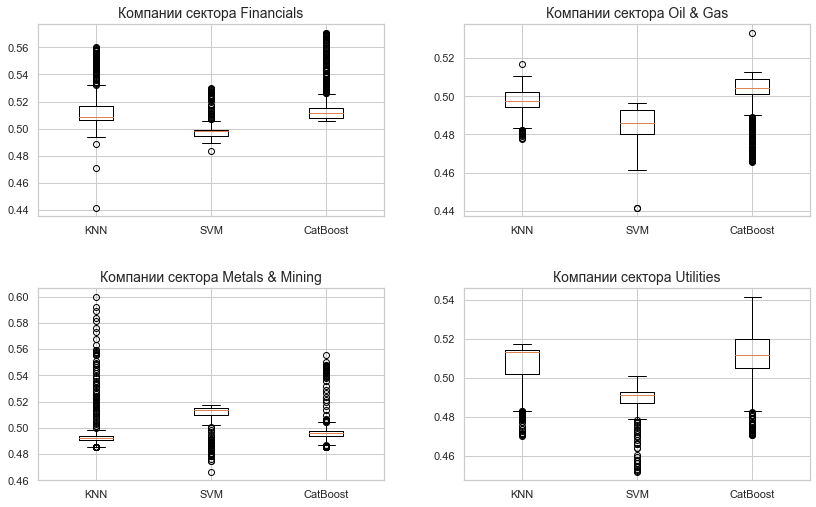

In [1139]:
sns.set()
sns.set_style("whitegrid")

fig, ax = plt.subplots(2,2, figsize=(12.5,8))
fig.tight_layout(pad=4.0)

ax[0,0].boxplot(x=[knn_port_acc['financials'], svm_port_acc['financials'],
                 cat_port_acc['financials']], 
               labels = ['KNN', 'SVM', 'CatBoost'])
ax[0,0].set_title("Компании сектора Financials", fontsize = fontsize)



ax[0,1].boxplot(x=[knn_port_acc['oilngas'], svm_port_acc['oilngas'],
                 cat_port_acc['oilngas']], 
               labels = ['KNN', 'SVM', 'CatBoost'])
ax[0,1].set_title("Компании сектора Oil & Gas", fontsize = fontsize)



ax[1,0].boxplot(x=[knn_port_acc['mm'], svm_port_acc['mm'],
                 cat_port_acc['mm']], 
               labels = ['KNN', 'SVM', 'CatBoost'])
ax[1,0].set_title("Компании сектора Metals & Mining", fontsize = fontsize)



ax[1,1].boxplot(x=[knn_port_acc['utilities'], svm_port_acc['utilities'],
                 cat_port_acc['utilities']], 
               labels = ['KNN', 'SVM', 'CatBoost'])
ax[1,1].set_title("Компании сектора Utilities", fontsize = fontsize)

In [1049]:
fin_dict = {}
for stock in ['HYDR.ME', 'FEES.ME', 'MSNG.ME', 'IRAO.ME']:
    fin_dict[f'{stock}_obs'] = list(true_observ[stock][-len(cat_final_preds_dict[stock]):].values)
    fin_dict[f'{stock}_preds'] = list(cat_final_preds_dict[stock])
    
for key in fin_dict.keys():
    if len(fin_dict[key]) == 631:
        fin_dict[key].append('xx')
        fin_dict[key].append('xx')
    elif len(fin_dict[key]) == 632:
        fin_dict[key].append('xx')
        
fin_df = pd.DataFrame(data = fin_dict)
fin_df[fin_df == 'xx'] = np.nan
fin_df.dropna(inplace = True)

fin_df.loc[fin_df['HYDR.ME_preds'] == 0, 'HYDR.ME_preds'] = -1
fin_df['hydr_trade'] = fin_df['HYDR.ME_preds'] * fin_df['HYDR.ME_obs'] - np.log(1.00018)
fin_df['hydr_trade_cumsum'] = fin_df['hydr_trade'].cumsum()

fin_df.loc[fin_df['FEES.ME_preds'] == 0, 'FEES.ME_preds'] = -1
fin_df['fees_trade'] = fin_df['FEES.ME_preds'] * fin_df['FEES.ME_obs'] - np.log(1.00018)
fin_df['fees_trade_cumsum'] = fin_df['fees_trade'].cumsum()

fin_df.loc[fin_df['MSNG.ME_preds'] == 0, 'MSNG.ME_preds'] = -1
fin_df['msng_trade'] = fin_df['MSNG.ME_preds'] * fin_df['MSNG.ME_obs'] - np.log(1.00018)
fin_df['msng_trade_cumsum'] = fin_df['msng_trade'].cumsum()

fin_df.loc[fin_df['IRAO.ME_preds'] == 0, 'IRAO.ME_preds'] = -1
fin_df['irao_trade'] = fin_df['IRAO.ME_preds'] * fin_df['IRAO.ME_obs'] - np.log(1.00018)
fin_df['irao_trade_cumsum'] = fin_df['irao_trade'].cumsum()

fin_df['irao_real_ret'] = fin_df['IRAO.ME_obs'].cumsum()
fin_df['msng_real_ret'] = fin_df['MSNG.ME_obs'].cumsum()
fin_df['fees_real_ret'] = fin_df['FEES.ME_obs'].cumsum()
fin_df['hydr_real_ret'] = fin_df['HYDR.ME_obs'].cumsum()

real_port_ret = []
pred_port_ret = []

for i in range(len(fin_df)):
    real_port_ret.append(np.log((np.exp(fin_df['IRAO.ME_obs'][i]) + np.exp(fin_df['MSNG.ME_obs'][i]) +
                         np.exp(fin_df['FEES.ME_obs'][i]) + np.exp(fin_df['HYDR.ME_obs'][i])) / 4))
    
    pred_port_ret.append(np.log((np.exp(fin_df['irao_trade'][i]) + np.exp(fin_df['msng_trade'][i]) +
                         np.exp(fin_df['fees_trade'][i]) + np.exp(fin_df['hydr_trade'][i])) / 4))
    
fin_df['real_port_ret'] = real_port_ret
fin_df['pred_port_ret'] = pred_port_ret

fin_df['real_port_ret_cumsum'] = np.exp(fin_df['real_port_ret'].cumsum()-1)
fin_df['pred_port_ret_cumsum'] = np.exp(fin_df['pred_port_ret'].cumsum()-1)


In [1221]:
fin_total_dataframe = copy.deepcopy(fin_df)
oil_total_dataframe = copy.deepcopy(fin_df)
mm_total_dataframe = copy.deepcopy(fin_df)
util_total_dataframe = copy.deepcopy(fin_df)


plt.plot(fin_total_dataframe['real_port_ret_cumsum'])#blue line is real port return 
plt.plot(fin_total_dataframe['fin_perc_ret'])

In [1220]:
pred_port_ret = []

for i in range(len(fin_df)):

    pred_port_ret.append(np.log((np.exp(fin_total_dataframe['afks_trade'][i]) + np.exp(fin_total_dataframe['moex_trade'][i]) +
                         np.exp(fin_total_dataframe['sber_trade'][i]) + np.exp(fin_total_dataframe['vtbr_trade'][i])) / 4))
    
fin_total_dataframe['pred_port_ret'] = pred_port_ret
fin_total_dataframe

In [1218]:
util_total_dataframe['real_port_classes'] = -1
util_total_dataframe.loc[util_total_dataframe['real_port_ret'] > 0, 'real_port_classes'] = 1

fin_total_dataframe['real_port_classes'] = -1
fin_total_dataframe.loc[fin_total_dataframe['real_port_ret'] > 0, 'real_port_classes'] = 1

mm_total_dataframe['real_port_classes'] = -1
mm_total_dataframe.loc[mm_total_dataframe['real_port_ret'] > 0, 'real_port_classes'] = 1

oil_total_dataframe['real_port_classes'] = -1
oil_total_dataframe.loc[oil_total_dataframe['real_port_ret'] > 0, 'real_port_classes'] = 1

fin_true = fin_total_dataframe.loc[fin_total_dataframe['real_port_classes'] == fin_total_dataframe['port_pred_classes']]
fin_false = fin_total_dataframe.loc[fin_total_dataframe['real_port_classes'] != fin_total_dataframe['port_pred_classes']]

oil_true = fin_total_dataframe.loc[oil_total_dataframe['real_port_classes'] == oil_total_dataframe['port_pred_classes']]
oil_false = fin_total_dataframe.loc[oil_total_dataframe['real_port_classes'] != oil_total_dataframe['port_pred_classes']]

mm_true = fin_total_dataframe.loc[mm_total_dataframe['real_port_classes'] == mm_total_dataframe['port_pred_classes']]
mm_false = fin_total_dataframe.loc[mm_total_dataframe['real_port_classes'] != mm_total_dataframe['port_pred_classes']]

util_true = fin_total_dataframe.loc[util_total_dataframe['real_port_classes'] == util_total_dataframe['port_pred_classes']]
util_false = fin_total_dataframe.loc[util_total_dataframe['real_port_classes'] != util_total_dataframe['port_pred_classes']]

In [1217]:
results = stats.ttest_ind(
    fin_false['pred_port_ret'], 
    fin_true['pred_port_ret'],
    equal_var=False) 

print('p-значение:', results.pvalue)

p-значение: 0.99730692978724


In [1089]:
#fin_a = copy.deepcopy(fin_total_dataframe['pred_port_ret'])

fin_a = fin_total_dataframe['pred_port_ret'].cumsum()

fin_perc_ret_pred = [1]
for i in range(len(fin_a)):
    fin_perc_ret_pred.append(np.exp(fin_a[i]))

    
    
fin_b = fin_total_dataframe['real_port_ret'].cumsum()

fin_perc_ret_real = [1]
for i in range(len(fin_a)):
    fin_perc_ret_real.append(np.exp(fin_b[i]))

In [1109]:
fin_perc_ret_real = [x - 100 for x in fin_perc_ret_real]
fin_perc_ret_pred= [x -100 for x in fin_perc_ret_pred]

oil_perc_ret_real= [x - 100 for x in oil_perc_ret_real]
oil_perc_ret_pred= [x - 100 for x in oil_perc_ret_pred]

mm_perc_ret_real= [x -100 for x in mm_perc_ret_real]
mm_perc_ret_pred= [x - 100 for x in mm_perc_ret_pred]

util_perc_ret_pred= [x - 100 for x in util_perc_ret_pred]
util_perc_ret_real= [x - 100 for x in util_perc_ret_real]


In [1178]:
fin_diff = [fin_perc_ret_pred[x] - fin_perc_ret_real[x] - 100 for x in range(len(fin_perc_ret_real))] 
ir_fin = (28 - 40.7) / np.std(fin_diff)

oil_diff = [oil_perc_ret_pred[x] - oil_perc_ret_real[x] - 100 for x in range(len(oil_perc_ret_real))] 
ir_oil = (22.6 - 15.5) / np.std(oil_diff)

mm_diff = [mm_perc_ret_pred[x] - mm_perc_ret_real[x] for x in range(len(mm_perc_ret_real))] 
ir_mm = (35.2 - 26.4) / np.std(mm_diff)

util_diff = [util_perc_ret_pred[x] - util_perc_ret_real[x] for x in range(len(util_perc_ret_real))] 
ir_util = (16.1 + 11.4) / np.std(util_diff)

print('ir_fin', ir_fin)
print('ir_oil', ir_oil)
print('ir_mm', ir_mm)
print('ir_util', ir_util)

ir_fin -0.6465030758420348
ir_oil 0.27570702836727884
ir_mm 0.4806236500334364
ir_util 1.8049808167388735


In [1111]:
print(fin_perc_ret_real[-1])
print(fin_perc_ret_pred[-1])
print(oil_perc_ret_real[-1])
print(oil_perc_ret_pred[-1])
print(mm_perc_ret_real[-1])
print(mm_perc_ret_pred[-1])
print(util_perc_ret_pred[-1])
print(util_perc_ret_real[-1])

40.71690642096374
27.966396727039495
15.455550836518015
22.576940988109115
26.421731344158175
35.19634716379409
16.053546645129813
-11.377741147835025


Text(0.5, 1.0, 'Компании сектора Utilities')

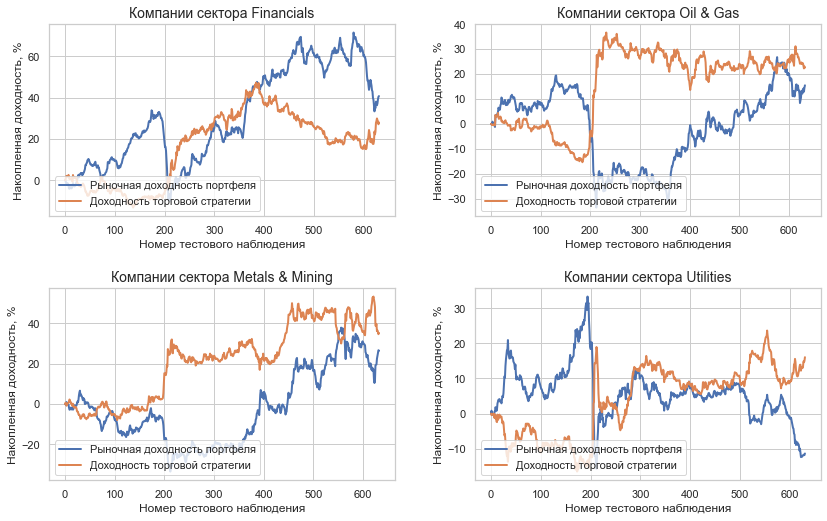

In [1159]:
sns.set()
sns.set_style("whitegrid")
fig, ax = plt.subplots(2,2, figsize=(12.5,8))

fig.tight_layout(pad=4.0)

ax[0,0].plot(fin_perc_ret_real, linewidth = 2, label = "Рыночная доходность портфеля")
ax[0,0].plot(fin_perc_ret_pred, linewidth = 2, label = "Доходность торговой стратегии")
ax[0,0].legend(loc='lower left')
ax[0,0].set(xlabel='Номер тестового наблюдения', ylabel='Накопленная доходность, %')
ax[0,0].set_title("Компании сектора Financials", fontsize = fontsize)


ax[0,1].plot(oil_perc_ret_real, linewidth = 2, label = "Рыночная доходность портфеля")
ax[0,1].plot(oil_perc_ret_pred, linewidth = 2, label = "Доходность торговой стратегии")
ax[0,1].legend(loc='lower left')
ax[0,1].set(xlabel='Номер тестового наблюдения', ylabel='Накопленная доходность, %')
ax[0,1].set_title("Компании сектора Oil & Gas", fontsize = fontsize)


ax[1,0].plot(mm_perc_ret_real, linewidth = 2, label = "Рыночная доходность портфеля")
ax[1,0].plot(mm_perc_ret_pred, linewidth = 2, label = "Доходность торговой стратегии")
ax[1,0].legend(loc='lower left')
ax[1,0].set(xlabel='Номер тестового наблюдения', ylabel='Накопленная доходность, %')
ax[1,0].set_title("Компании сектора Metals & Mining", fontsize = fontsize)


ax[1,1].plot(util_perc_ret_real, linewidth = 2, label = "Рыночная доходность портфеля")
ax[1,1].plot(util_perc_ret_pred, linewidth = 2, label = "Доходность торговой стратегии")
ax[1,1].legend(loc='lower left')
ax[1,1].set(xlabel='Номер тестового наблюдения', ylabel='Накопленная доходность, %')
ax[1,1].set_title("Компании сектора Utilities", fontsize = fontsize)

In [1060]:
observ = pd.DataFrame.from_dict(true_observ)
observ.columns = ["SBER_obs", "MOEX_obs","VTBR_obs","AFKS_obs","NLMK_obs","MAGN_obs","CHMF_obs","MTLR_obs", 
                  "LKOH_obs","NVTK_obs","ROSN_obs","GAZP_obs","HYDR_obs","FEES_obs","MSNG_obs","IRAO_obs"]
observ.dropna(inplace = True)

old_col = list(observ.columns)
names = ["SBER_cl", "MOEX_cl","VTBR_cl","AFKS_cl","NLMK_cl","MAGN_cl","CHMF_cl","MTLR_cl", 
         "LKOH_cl","NVTK_cl","ROSN_cl","GAZP_cl","HYDR_cl","FEES_cl","MSNG_cl","IRAO_cl"]

for col in tqdm(observ.columns):
    new_col = []
    for i in range(len(observ[col])):
        if observ[col][i] > 0:
            new_col.append(1)
        elif observ[col][i] <= 0:
            new_col.append(0)
    observ[names[old_col.index(col)]] = new_col
    
    
    
financials = observ[["SBER_obs", "MOEX_obs","VTBR_obs","AFKS_obs","SBER_cl", "MOEX_cl","VTBR_cl","AFKS_cl"]]
metalsnmining = observ[["NLMK_obs","MAGN_obs","CHMF_obs","MTLR_obs","NLMK_cl","MAGN_cl","CHMF_cl","MTLR_cl"]]
oilngas = observ[["LKOH_obs","NVTK_obs","ROSN_obs","GAZP_obs","LKOH_cl","NVTK_cl","ROSN_cl","GAZP_cl"]]
utilities = observ[["HYDR_obs","FEES_obs","MSNG_obs","IRAO_obs","HYDR_cl","FEES_cl","MSNG_cl","IRAO_cl"]]



ERROR! Session/line number was not unique in database. History logging moved to new session 425


100%|███████████████████████████████████████████| 16/16 [00:00<00:00, 69.63it/s]


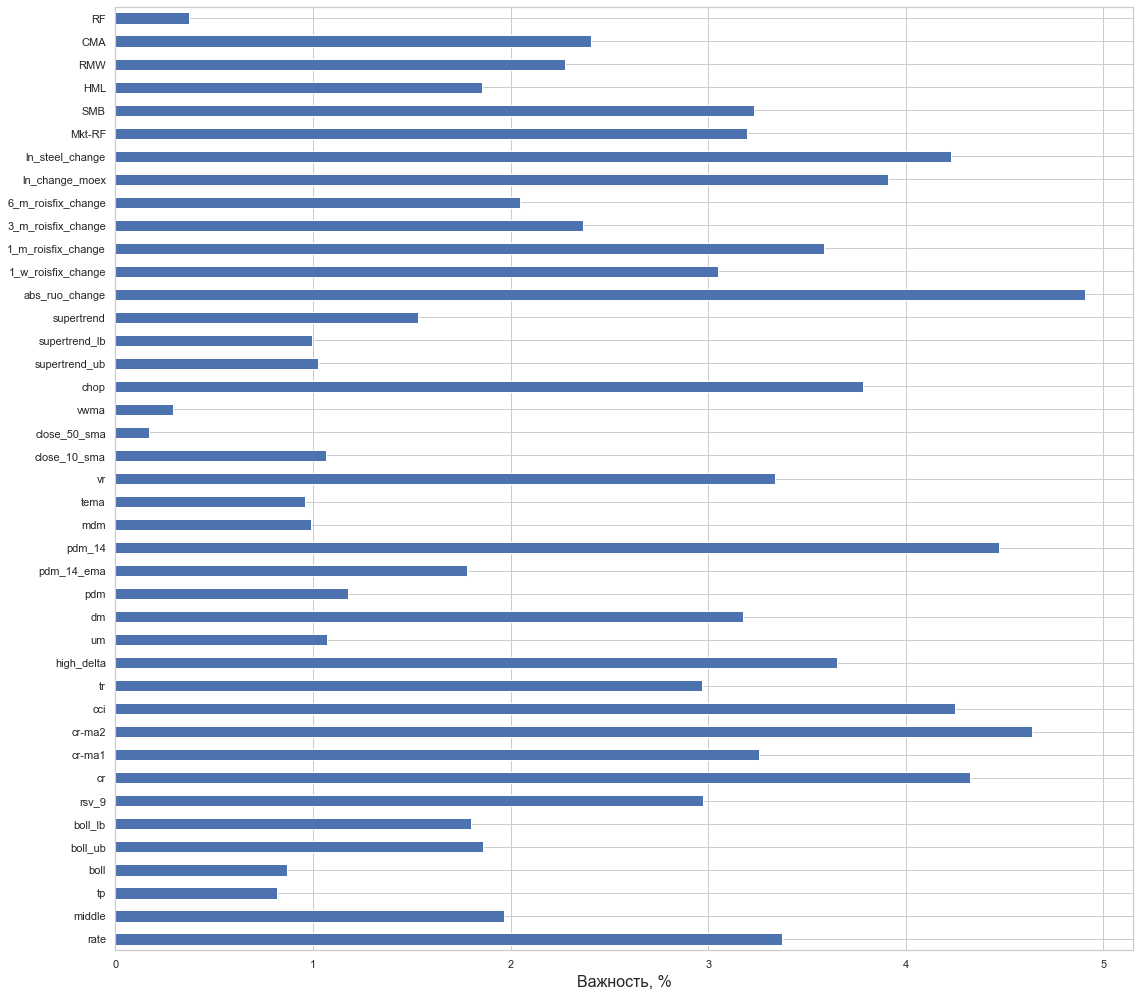

In [1114]:
cat_iris_imp = pd.Series(clf.get_feature_importance(), df_selected.columns)
fig, ax = plt.subplots(figsize=(16,14))
cat_iris_imp.plot.barh(ax=ax)
ax.set_xlabel('Важность, %', size = 16)
fig.tight_layout()

# Bi-LSTM NN

In [1219]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D
import copy
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

y_classified = []

for val in y.values:
    if val > 0:
        y_classified.append([1,0])
    elif val <= 0:
        y_classified.append([0,1])

sc = StandardScaler()

data = df_selected.values
data_scaled = sc.fit_transform(data)

sequence_length = 500
X = []
data_y = []

for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i - sequence_length:i])
    data_y.append(y_classified[i])
    
data_y = np.array(data_y)
X = np.array(X)

X_train, X_test, y_train, y_test = train_test_split(X, data_y, test_size=0.2, shuffle=False)

model = Sequential([
    Conv1D(filters=64, kernel_size=4, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Bidirectional(LSTM(units=50, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=50, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(units=50)),
    Dropout(0.2),
    Dense(units=2, activation='softmax')
])

model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(X_train, y_train, epochs = 7, batch_size=64, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)